## Simulate and Plot Data

In [3]:
import numpy as np
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random as random
import pandas as pd
import seaborn as sns

import pfjax as pf
from pfjax import proj_data, LotVolModel
import pfjax.sde

key = random.PRNGKey(0)

# parameter values

alpha = 1.0
beta = 1.0
gamma = 4.0
delta = 1.0
sigma_h = 0.1
sigma_l = 0.1
tau_h = 0.1
tau_l = 0.1

theta = jnp.array([alpha, beta, gamma, delta, sigma_h, sigma_l, tau_h, tau_l])

dt = 0.1
n_res = 2
n_obs = 100
lotvol_model = LotVolModel(dt, n_res) 
# key, subkey = random.split(key)


x_init = jnp.block([[jnp.zeros((n_res-1, 2))],
                    [jnp.log(jnp.array([5., 3.]))]])

y_meas, x_state = pf.simulate(lotvol_model, key, n_obs, x_init, theta)


Plotting the observations of the state (latent variables) as well as the observations. The latent observations are the smooth lines given below and the observations are the slightly more jagged lines.

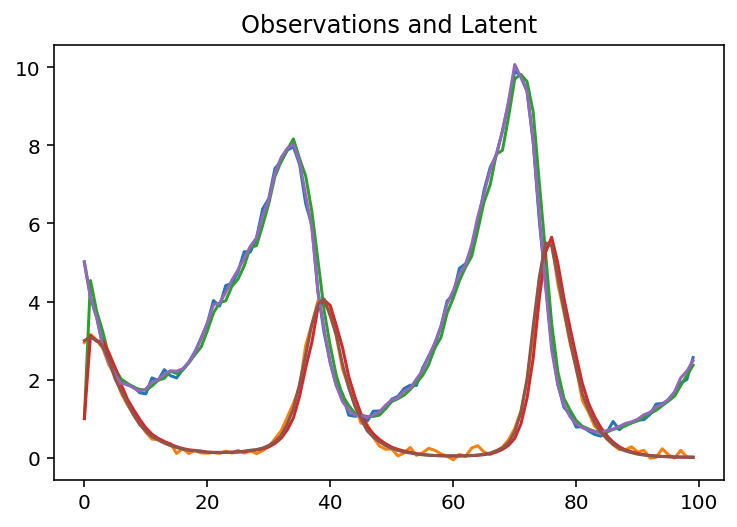

In [5]:
import matplotlib.pyplot as plt
plt.plot(y_meas[:, 0])
plt.plot(y_meas[:, 1])
plt.plot(jnp.exp(x_state[:,0]))
plt.plot(jnp.exp(x_state[:, 1]))
plt.title("Observations and Latent");

## Parameter Estimation with Complete Data

In other words, we estimate $\theta$ as if both $y_{0:T}$ and $x_{0:T}$ were known.  Let's start with projection plots of the complete data (log)likelihood

$$
\ell(\theta \mid x_{0:T}, y_{0:T}) = \log p(y_0 \mid x_0, \theta) + \sum_{t=1}^T \log p(y_t \mid x_t, \theta) + \log p(x_t \mid x_{t-1}, \theta).
$$

In [7]:
theta_lims = np.array([[0., 2.], [.75, 1.2], [2.0, 6.0], [0., 2.],
                       [.000001, .4], [.05, .4], [.1, .5], [.1, .5]])
theta_names = ["alpha", "beta", "gamma", "delta",
               "sigma_h", "sigma_l", "tau_h", "tau_l"]
n_pts = 100

# calculate projection plot


# @jax.jit
# def lotvol_loglik(theta):
#     return pf.joint_loglik(model=lotvol_model, theta=theta, x_state=x_state, y_meas=y_meas)


# plot_df = proj_data(lotvol_loglik,
#                     theta, theta_lims, theta_names)

# sns.relplot(
#     data=plot_df, kind="line",
#     x="x", y="y", col="theta",
#     col_wrap = 4,
#     facet_kws=dict(sharex=False, sharey=False)
# )

## Parameter Estimation with Particle Filter

In [8]:
theta_lims = np.array([[0.8, 1.2], [0.8, 1.2], [3.8, 4.2], [0.8, 1.2], [0.01, 4.], [0.01, 4.], [0.01, 2.], [0.01, 2.]])
theta_names = ["alpha", "beta", "gamma", "delta", "sigma_h", "sigma_l", "tau_h", "tau_l"]
n_pts = 100

# calculate projection plot
n_particles = 1000


@jax.jit
def lotvol_pflik(theta):
    temp = pf.particle_filter(theta=theta, model=lotvol_model, y_meas=y_meas,
                              n_particles=n_particles, key=key)
    return pf.particle_loglik(temp['logw'])


plot_df = proj_data(lotvol_pflik,
                    theta, theta_lims, theta_names)

sns.relplot(
    data=plot_df, kind="line",
    x="x", y="y", col="theta",
    col_wrap = 4,
    facet_kws=dict(sharex=False, sharey=False)
)

TypeError: Invalid PRNG key data Traced<ShapedArray(float32[2])>with<DynamicJaxprTrace(level=0/1)> for PRNG implementation PRNGImpl(key_shape=(2,), seed=<function threefry_seed at 0x7fb6855c5950>, split=<function threefry_split at 0x7fb6855c73b0>, random_bits=<CompiledFunction of <function threefry_random_bits at 0x7fb6855c7b90>>, fold_in=<function threefry_fold_in at 0x7fb6855c77a0>)

### Stochastic Optimization

For now, we initialize it to be the starting values that were chosen. In addition to this, we also initialize the mask array to be this so that we can verify the results on a one dimensional optimization problem.

In [3]:
from pfjax import stoch_opt, get_sum_lweights


It appears like the value of `sigma_h` and `sigma_l` are extremely important in determining the objective function values.

In [6]:
print(key)
params = stoch_opt(lotvol_model, jnp.array([1.,1., 4., 1., 0.1, 0.1, 0.1, 0.1]), get_sum_lweights, y_meas, key=key, learning_rate=0.0001, iterations=100, n_particles=500,
         mask=np.array([1,1,1,1,1,1,1,1]))

[0 0]
[1.01       0.99000007 4.0099998  0.99000007 0.09000007 0.10999993
 0.10999993 0.10999993]
[1.02       0.98000014 4.0199995  0.98000014 0.1        0.11999986
 0.11999986 0.11999986]
[1.03       0.9700002  4.0299993  0.9700002  0.10999993 0.1299998
 0.1299998  0.1299998 ]
[1.02       0.98000014 4.0199995  0.9600003  0.11999986 0.13999973
 0.13999973 0.13999973]
[1.01       0.99000007 4.0099998  0.95000035 0.1299998  0.14999966
 0.14999966 0.14999966]
[1.         1.         3.9999998  0.9400004  0.13999973 0.1599996
 0.1599996  0.1599996 ]
[0.99000007 1.01       3.9899998  0.95000035 0.14999966 0.16999952
 0.16999952 0.16999952]
[1.         1.02       3.9999998  0.9400004  0.1599996  0.17999946
 0.17999946 0.17999946]
[0.99000007 1.03       3.9899998  0.9300005  0.16999952 0.18999939
 0.18999939 0.18999939]
[0.98000014 1.04       3.9999998  0.92000055 0.17999946 0.19999932
 0.19999932 0.19999932]
[0.9700002  1.05       3.9899998  0.9300005  0.18999939 0.20999925
 0.20999925 0.20999

Text(0.5, 1.0, 'Gradient')

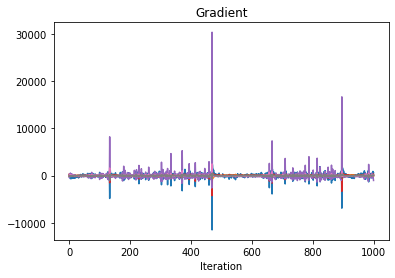

In [35]:
plt.plot(grads)
plt.title("Gradient of Alpha")
plt.xlabel("Iteration")
plt.title("Gradient")

Text(0, 0.5, 'Stochastic Objective Value')

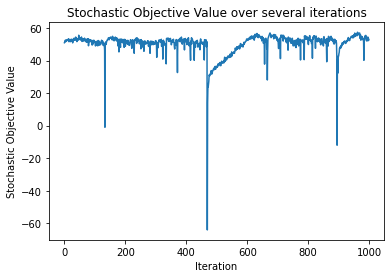

In [36]:
plt.plot(so)
plt.title("Stochastic Objective Value over several iterations")
plt.xlabel("Iteration")
plt.ylabel("Stochastic Objective Value")

In [5]:
params

DeviceArray([0.9000007, 1.       , 3.9399998, 1.04     , 1.0599937,
             0.7999952, 1.0999937, 1.0999937], dtype=float32)

## Scratch

In [ ]:
n_particles = 10

pf_out = pf.particle_filter(theta=theta, model=lotvol_model, y_meas=y_meas,
                              n_particles=n_particles, key=key)

In [ ]:
i_obs = 1
print(pf_out["X_particles"][i_obs])
print(y_meas[i_obs])

In [ ]:
theta

In [ ]:
@jax.jit
def lotvol_pflik(theta, key):
    temp = pf.particle_filter(theta=theta, model=lotvol_model, y_meas=y_meas,
                              n_particles=n_particles, key=key)
    return pf.particle_loglik(temp['logw_particles'])

n_particles = 100

i_theta = 0 # which index of theta to update
theta_min = theta_lims[i_theta][0]
theta_max = theta_lims[i_theta][1]
#theta_min = 3.0
#theta_max = 5.0
theta_seq = np.linspace(theta_min, theta_max, num=n_pts)
ll_seq = np.zeros(theta_seq.shape)
for i in range(n_pts):
    key, subkey = random.split(key)
    theta_tmp = theta
    theta_tmp[i_theta] = theta_seq[i]
    ll_seq[i] = lotvol_pflik(theta_tmp, subkey)
    #theta_tmp = theta_tmp.at[0].set(alpha_seq[i])
    #ll_seq = ll_seq.at[i].set(lotvol_pflik(theta_tmp, subkey))

plt.plot(theta_seq, ll_seq)